# Numerical analysis of transition to chaos (unstructured networks)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from ntwk import SoftmaxNtwk
from disp import set_plot, set_color

In [2]:
NTR = 10  # num trials per network config
TPRE = 10  # pre-simulation time for sampling init conds
TSMLN = 20  # simulation time for gain est
NITER = 10  # number of iterations for critical gain estimation alg

## Adaptive algorithm for critical gain estimation

First compute separation rate $\lambda(g)$ at lower and upper bounds $g_{lb}$ and $g_{ub}$ s.t. $\lambda(g_{lb}) < 0 < \lambda(g_{ub})$. Then iterate $N_g$ times:

Let $g_{test} = (g_{lb} + g_{ub})/2$.

Estimate $\lambda(g_{test})$.

If $\lambda(g_{test}) < 0$, then $g_{lb} \leftarrow g_{test}$. Else $g_{ub} \leftarrow g_{test}$.

After $N_g$ iterations, approximate $g_c = (g_{lb} + g_{ub})/2$.

In [3]:
RS_G_LB_G_UB = [
    (2, 2, 5),
    (4, 1, 2),
    (6, 1, 2),
    (8, .75, 1.25),
    (12, .5, 1),
    (16, .5, 1),
    (24, .5, 1),
    (32, .5, 1),
]
RS = list(zip(*RS_G_LB_G_UB))[0]

NS = [100, 500, 1000, 2000]
# NS = [500, 1000]

## Run/save simulations

(takes a while)

In [4]:
def est_lam(t, ys, ys_ptb):
    """Estimate trajectory separation rate."""
    
    # rms separation dists btwn ys and ys_ptb over time
    dists = np.sqrt(np.mean((ys-ys_ptb)**2, axis=(1, 2)))
    
    # slope of log of separation distance vs time at start of smln
    lam = stats.linregress(t[:2], np.log(dists[:2]))[0]
    
    return lam


def run_smlns(ntwk, g, verbose=True):
    """Run baseline and perturbed simulation."""
    ys_all = []
    
    for ctr in range(NTR):
        
        x_0 = np.random.randn(N, R)
        
        # preparatory simulation
        if verbose:  sys.stdout.write('>')
        ys_pre = ntwk.run(g=g, t_max=TPRE, x_0=x_0)[-1]
        
        # unperturbed run
        y_0 = ys_pre[-1, :, :]
        
        if verbose:  sys.stdout.write('-')
        t, _, ys = ntwk.run(g=g, t_max=TSMLN, y_0=y_0)
        
        # perturbed run
        y_0_ptb = y_0.copy()
        
        # swap high/low vals within random row
        irow = np.random.randint(N)
        imin = y_0_ptb[irow, :].argmin()
        imax = y_0_ptb[irow, :].argmax()

        y_0_ptb[irow, imin] = y_0_ptb[irow].max()
        y_0_ptb[irow, imax] = y_0_ptb[irow].min()

        if verbose:  sys.stdout.write('-')
        t, _, ys_ptb = ntwk.run(g, t_max=TSMLN, y_0=y_0_ptb)
        
        ys_all.append([ys_pre, ys, ys_ptb])
    return t, ys_all

In [5]:
raise Exception
g_seqs = [[] for N in NS]
lam_seqs = [[] for N in NS]

for cN, N in enumerate(NS):
    for R, G_LB, G_UB in RS_G_LB_G_UB:
        print(f'N, R = {N, R}')
    
        # make ntwk
        J = np.random.randn(R, R, N, N)*np.sqrt(R/N)
        ntwk = SoftmaxNtwk(J)
        
        g_lb = G_LB
        g_ub = G_UB
        
        sys.stdout.write(f'g = {g_lb} ')
        t, ys_all_lb = run_smlns(ntwk, g=g_lb)
        lam_lb = np.mean([est_lam(t, ys, ys_ptb) for _, ys, ys_ptb in ys_all_lb])
        sys.stdout.write(f' lam = {lam_lb:.3f}\n')
        
        sys.stdout.write(f'g = {g_ub} ')
        t, ys_all_ub = run_smlns(ntwk, g=g_ub)
        lam_ub = np.mean([est_lam(t, ys, ys_ptb) for _, ys, ys_ptb in ys_all_ub])
        sys.stdout.write(f' lam = {lam_ub:.3f}\n')
        
        assert lam_lb < 0 < lam_ub
        
        g_seq = [G_LB, G_UB]
        lam_seq = [lam_lb, lam_ub]
        
        for citer in range(NITER-2):
            g = .5*(g_lb + g_ub)
            sys.stdout.write(f'g = {g} ')
            
            t, ys_all = run_smlns(ntwk, g=g)
            lam = np.mean([est_lam(t, ys, ys_ptb) for _, ys, ys_ptb in ys_all])
            
            sys.stdout.write(f' lam = {lam:.3f}\n')
            if lam < 0:
                g_lb = g  # make g new lower bound
            elif lam > 0:
                g_ub = g  # make g new upper bound
            
            g_seq.append(g)
            lam_seq.append(lam)
            
        g_seqs[cN].append(g_seq)
        lam_seqs[cN].append(lam_seq)
        print('')
        
np.save('data/chaos_transition_rand/gain_est_rslts.npy', np.array([{'NS': NS, 'RS': RS, 'g_seqs': g_seqs, 'lam_seqs': lam_seqs, 'NTR': NTR}]))

Exception: 

## Load/analyze simulations

In [6]:
data = np.load('data/chaos_transition_rand/gain_est_rslts.npy', allow_pickle=True)[0]
DS = data['RS']
NS = data['NS']
g_seqs = data['g_seqs']
lam_seqs = data['lam_seqs']

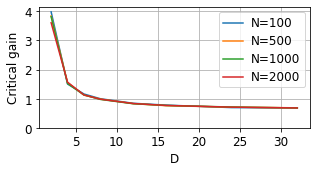

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.5), tight_layout=True)
for cN, N in enumerate(NS):
    gcs = np.array([g_seq[-1] for g_seq in g_seqs[cN]])
    ax.plot(DS, gcs)
    
ax.legend([f'N={N}' for N in NS])
ax.set_ylim(bottom=0)
ax.grid()
set_plot(ax, x_label='D', y_label='Critical gain')

fig.savefig('figs/main/1_critical_gain.svg')